In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential
from keras.applications import VGG16, VGG19, ResNet101

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [4]:
CLASS_NAMES = ['sehat', 'giberella', 'anthracnose']

def load_data(path, image_size=(224, 224)):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(CLASS_NAMES):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = tf.convert_to_tensor(images, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.uint8)

    return (images, labels)

In [5]:
def show_sample_images(data, n_images):

    images, labels = data

    fig, axs = plt.subplots(nrows=n_images, ncols=len(CLASS_NAMES), figsize=(9, 10),
                            subplot_kw={'xticks': [], 'yticks': []})

    for col in range(len(CLASS_NAMES)):
        sample = images[labels==col][:n_images]
        for row in range(n_images):
            axs[row][col].imshow(sample[row])
            axs[row][col].set_title(CLASS_NAMES[col])

    plt.tight_layout()
    plt.show()

In [6]:
def plot_distribution_data(train_data, val_data, test_data):
    amount = {
        'Train': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Val': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Test': [ 0 for _ in range(len(np.unique(train_data))) ],
    }

    # count amount of data train
    for clas in train_data:
        amount['Train'][clas] += 1

    # count amount of data val
    for clas in val_data:
        amount['Val'][clas] += 1

    # count amount of data test
    for clas in test_data:
        amount['Test'][clas] += 1

    x = np.arange(len(CLASS_NAMES))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in amount.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total')
    ax.set_title('Data distribution by classes')
    ax.set_xticks(x + width, CLASS_NAMES)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 100)

    plt.show()

In [7]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)
    axs[1].legend(['Train', 'Val'])

In [8]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data original

## VGG16

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train


100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


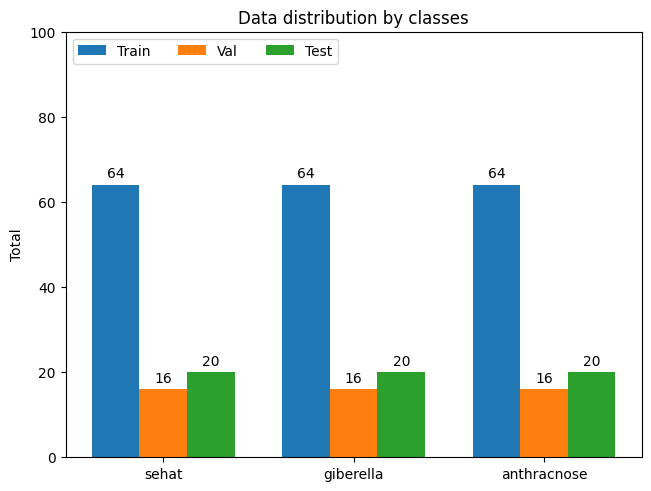

In [ ]:
plot_distribution_data(y_train, y_val, y_test)

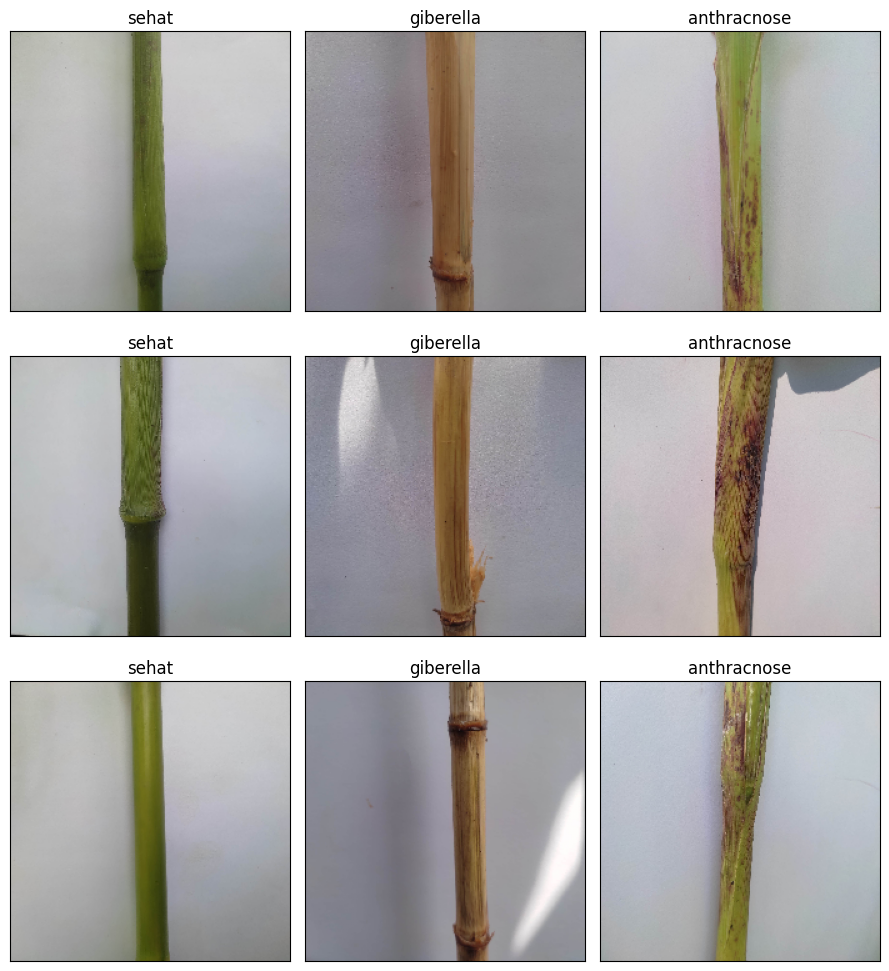

In [ ]:
show_sample_images(data=(X_train, y_train), n_images=3)

In [ ]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.3730 - loss: 1.0985
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3673 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3405 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 576ms/step - accuracy: 0.3394 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.3352 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.3350 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.3366 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.3362 - loss: 1.

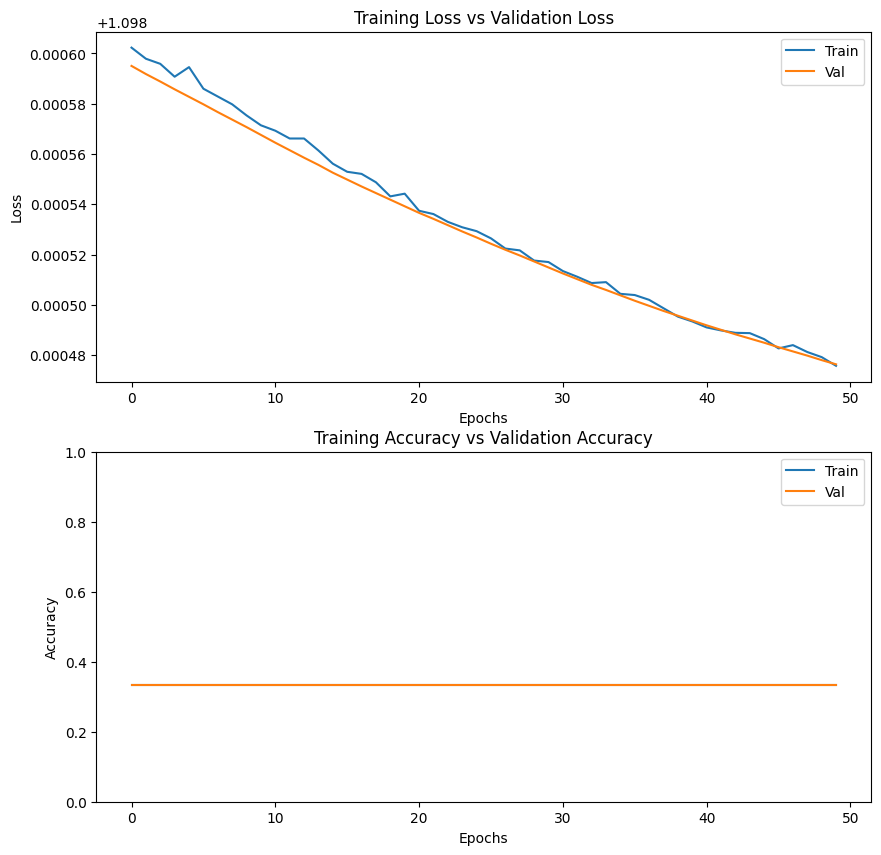

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 12s/step


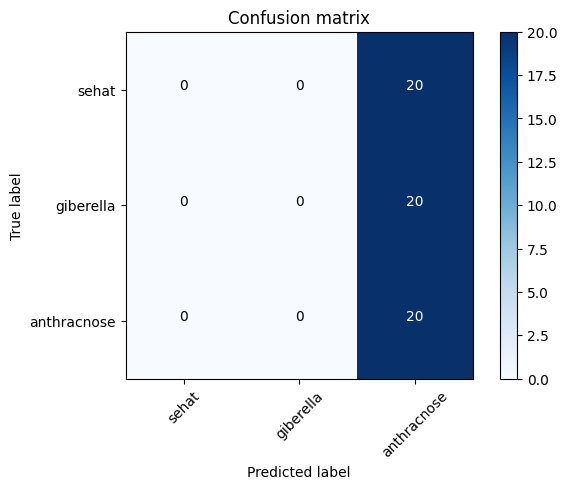

In [ ]:
model.load_weights('vgg16-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp vgg16-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSprop optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2626 - loss: 1.0997
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 87s 16s/step - accuracy: 0.2638 - loss: 1.0997 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.3559 - loss: 1.0982
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.3527 - loss: 1.0983 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3210 - loss: 1.0987
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.3176 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.3122 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.3145 - los

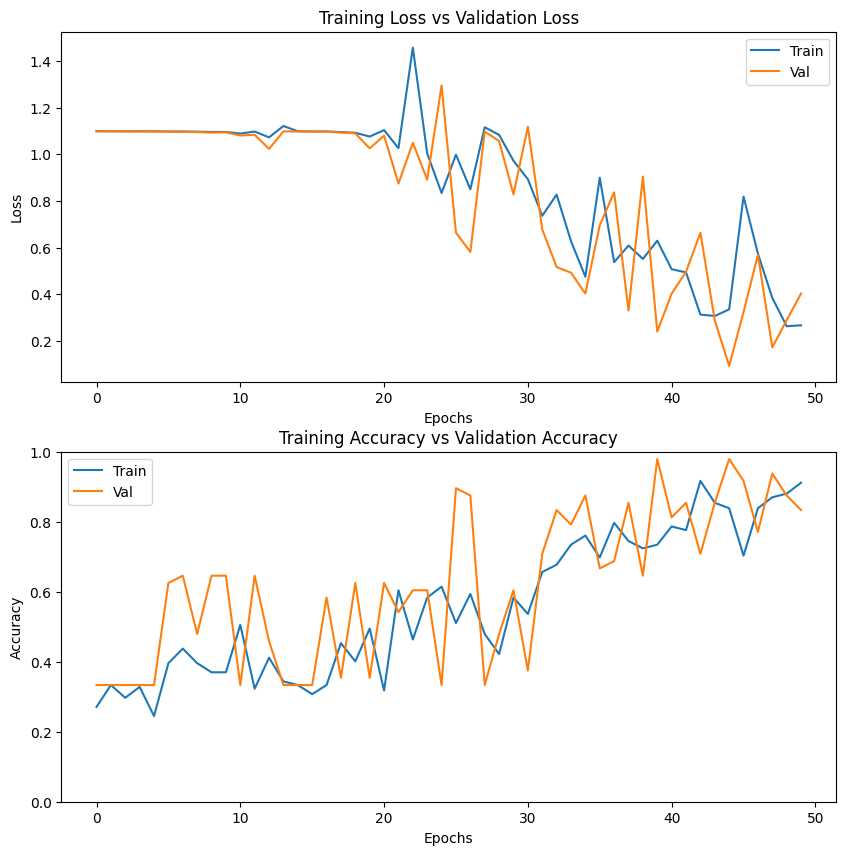

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


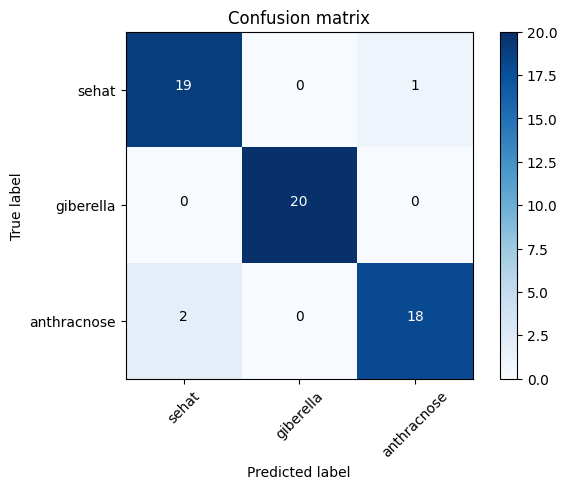

In [ ]:
model.load_weights('vgg16-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      1.00      1.00        20
           2       0.95      0.90      0.92        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [ ]:
!cp vgg16-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8968 - loss: 0.4360
Epoch 1: val_accuracy improved from -inf to 0.89583, saving model to vgg16-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 150s 28s/step - accuracy: 0.8892 - loss: 0.4507 - val_accuracy: 0.8958 - val_loss: 0.2585
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9392 - loss: 0.2415
Epoch 2: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 569ms/step - accuracy: 0.9360 - loss: 0.2452 - val_accuracy: 0.7708 - val_loss: 0.3634
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9537 - loss: 0.2099
Epoch 3: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.9536 - loss: 0.2094 - val_accuracy: 0.8750 - val_loss: 0.3352
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9224 - loss: 0.1513
Epoch 4: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.9238 - loss:

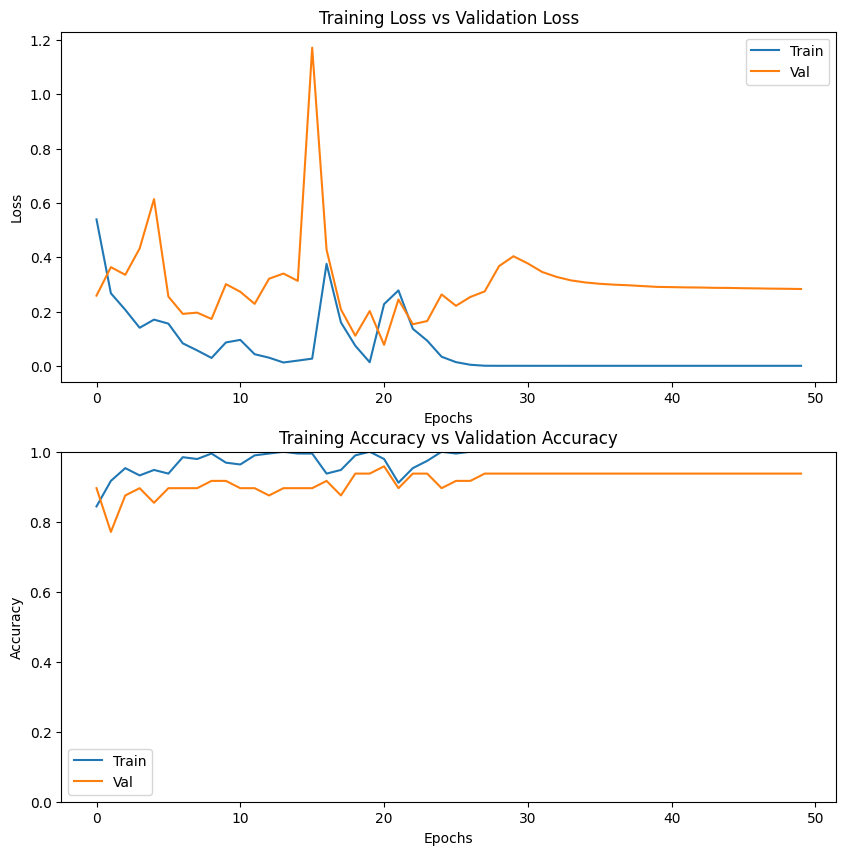

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 940ms/step


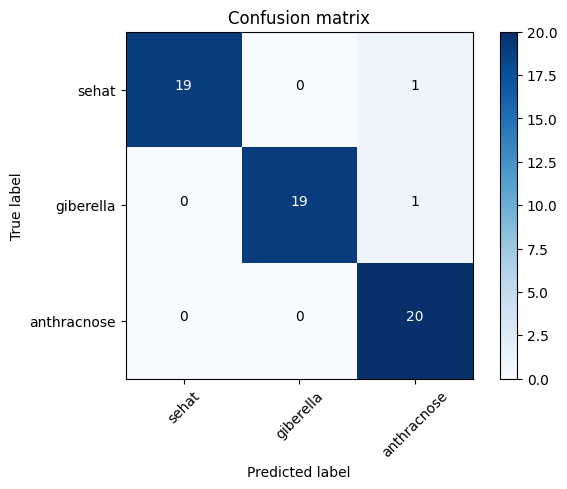

In [ ]:
model.load_weights('vgg16-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      0.95      0.97        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [ ]:
!cp vgg16-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## VGG19

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test")
X_test = X_test / 255

In [ ]:
model = VGG19(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3778 - loss: 1.0986
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3714 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3339 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step - accuracy: 0.3338 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.3420 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.3408 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3087 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 662ms/step - accuracy: 0.3122 - loss: 1.

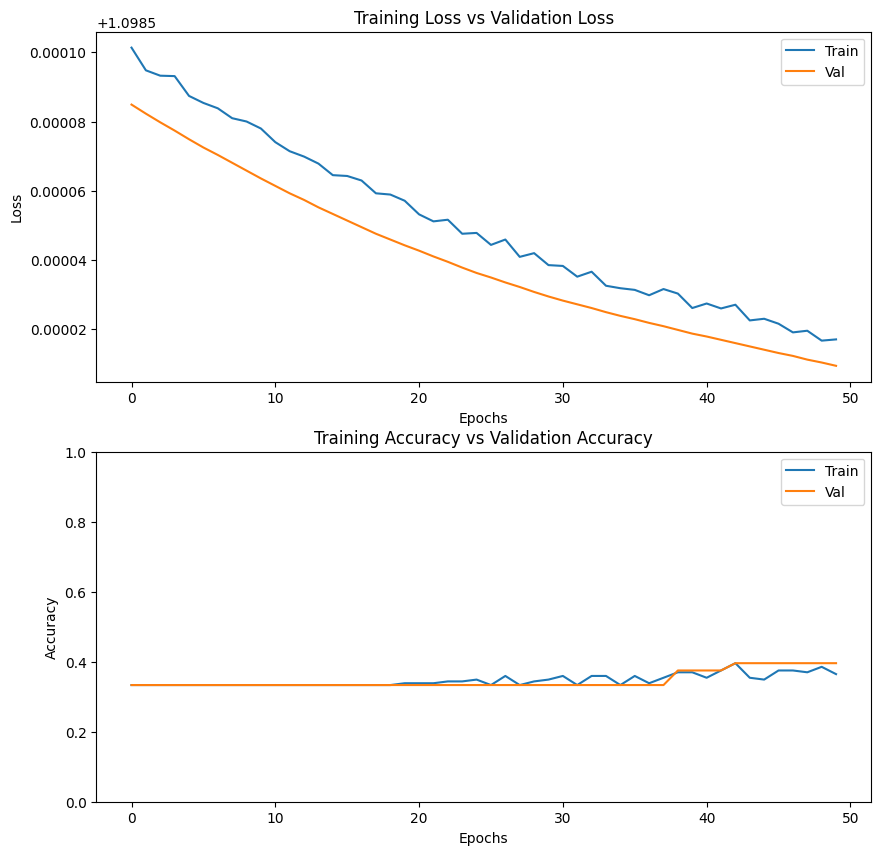

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 13s/step


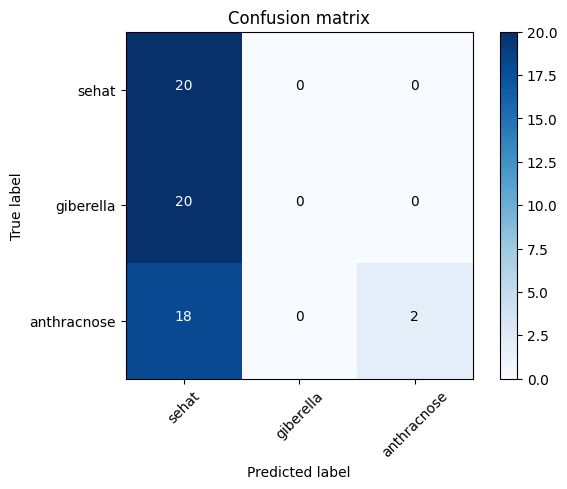

In [ ]:
model.load_weights('vgg19-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51        20
           1       0.00      0.00      0.00        20
           2       1.00      0.10      0.18        20

    accuracy                           0.37        60
   macro avg       0.45      0.37      0.23        60
weighted avg       0.45      0.37      0.23        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp vgg19-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSprop optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.3599 - loss: 1.0992
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.3561 - loss: 1.0992 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.3366 - loss: 1.0989
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step - accuracy: 0.3332 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.3395 - loss: 1.0985
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accuracy: 0.3371 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.2527 - loss: 1.0995
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.2590 - loss:

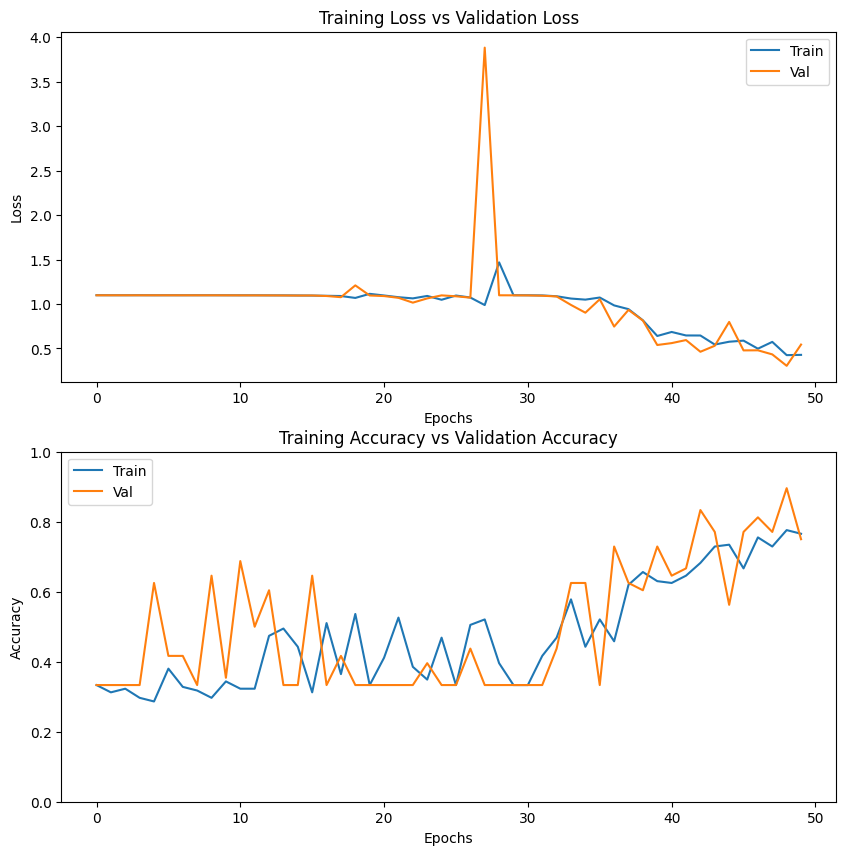

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 12s/step


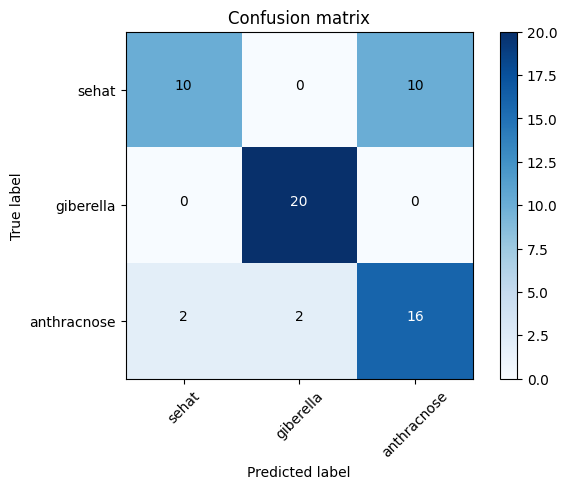

In [ ]:
model.load_weights('vgg19-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        20
           1       0.91      1.00      0.95        20
           2       0.62      0.80      0.70        20

    accuracy                           0.77        60
   macro avg       0.79      0.77      0.76        60
weighted avg       0.79      0.77      0.76        60



In [ ]:
!cp vgg19-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7320 - loss: 0.5418
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to vgg19-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.7361 - loss: 0.5406 - val_accuracy: 0.8542 - val_loss: 0.3919
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7418 - loss: 0.4513
Epoch 2: val_accuracy did not improve from 0.85417
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 735ms/step - accuracy: 0.7467 - loss: 0.4515 - val_accuracy: 0.8542 - val_loss: 0.3110
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8540 - loss: 0.3695
Epoch 3: val_accuracy improved from 0.85417 to 0.87500, saving model to vgg19-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.8570 - loss: 0.3678 - val_accuracy: 0.8750 - val_loss: 0.3091
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8925 - loss: 0.2742
Epoch 4: val_accuracy did not improve from 0.87500
6/6 ━━━━━━━━━━━━

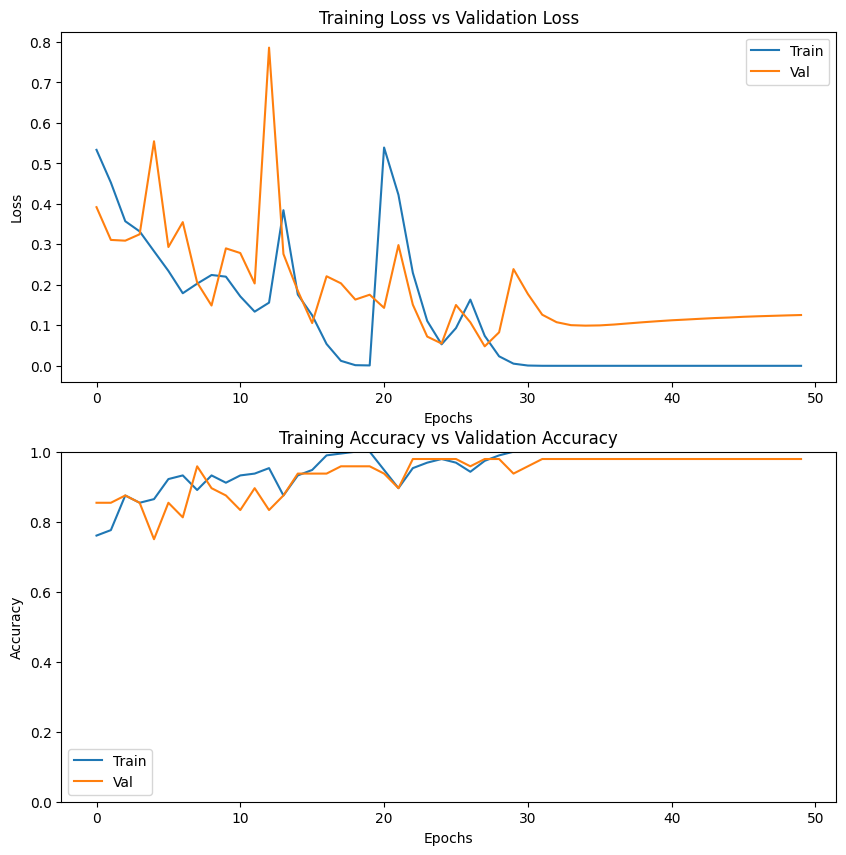

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 849ms/step


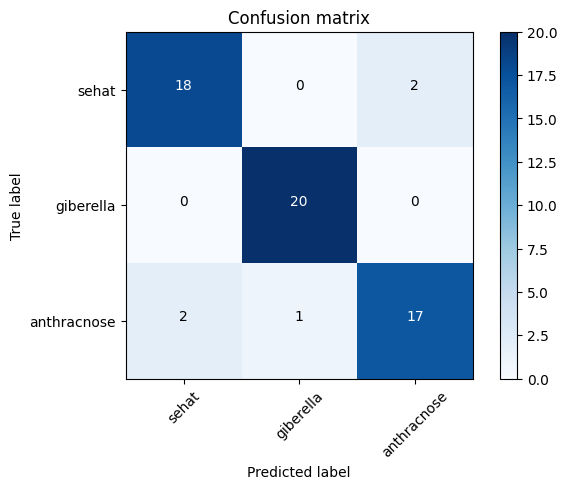

In [ ]:
model.load_weights('vgg19-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.95      1.00      0.98        20
           2       0.89      0.85      0.87        20

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [ ]:
!cp vgg19-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## AlexNet

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train", (227, 227))
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val", (227, 227))
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test", (227, 227))
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train


100%|██████████| 64/64 [00:39<00:00,  1.60it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val


100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


In [ ]:
model = Sequential([
    layers.Input(shape=(227, 227, 3)),
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Flatten(),
    layers.Dense(4096,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │          12,2

 Total params: 58,299,139 (222.39 MB)

 Trainable params: 58,296,387 (222.38 MB)

 Non-trainable params: 2,752 (10.75 KB)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3674 - loss: 2.2333
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to alexnet-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 836ms/step - accuracy: 0.3708 - loss: 2.2142 - val_accuracy: 0.3333 - val_loss: 1.0978
Epoch 2/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4968 - loss: 1.7480
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.4903 - loss: 1.7626 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 3/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4645 - loss: 1.6424
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4836 - loss: 1.5857 - val_accuracy: 0.3333 - val_loss: 1.0991
Epoch 4/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5286 - loss: 1.4048
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5175 - loss: 1.411

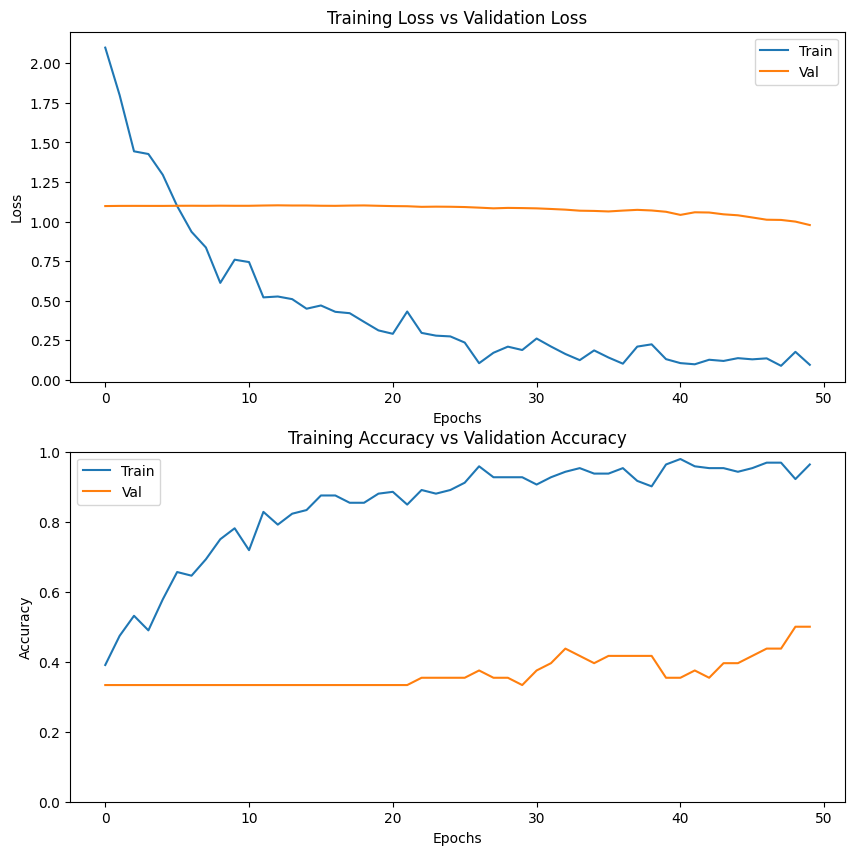

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


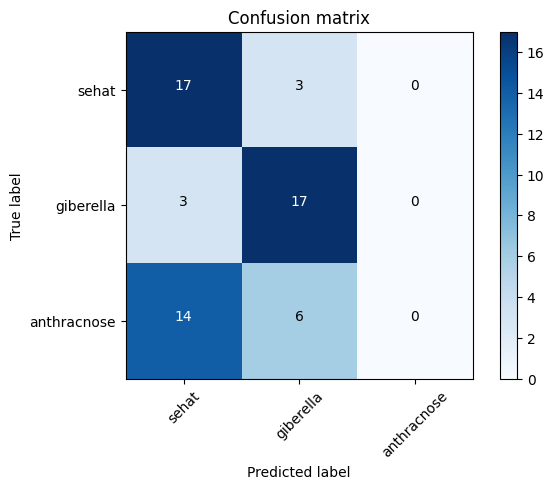

In [ ]:
model.load_weights('alexnet-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.85      0.63        20
           1       0.65      0.85      0.74        20
           2       0.00      0.00      0.00        20

    accuracy                           0.57        60
   macro avg       0.38      0.57      0.46        60
weighted avg       0.38      0.57      0.46        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp alexnet-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSPROP

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4039 - loss: 9.5871
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to alexnet-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 838ms/step - accuracy: 0.4094 - loss: 9.9074 - val_accuracy: 0.3333 - val_loss: 1.1030
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7632 - loss: 2.4235
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7792 - loss: 2.2497 - val_accuracy: 0.3333 - val_loss: 1.0888
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9899 - loss: 0.0206
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9891 - loss: 0.0229 - val_accuracy: 0.3333 - val_loss: 1.0907
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9766 - loss: 0.1002
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9747 - loss: 0

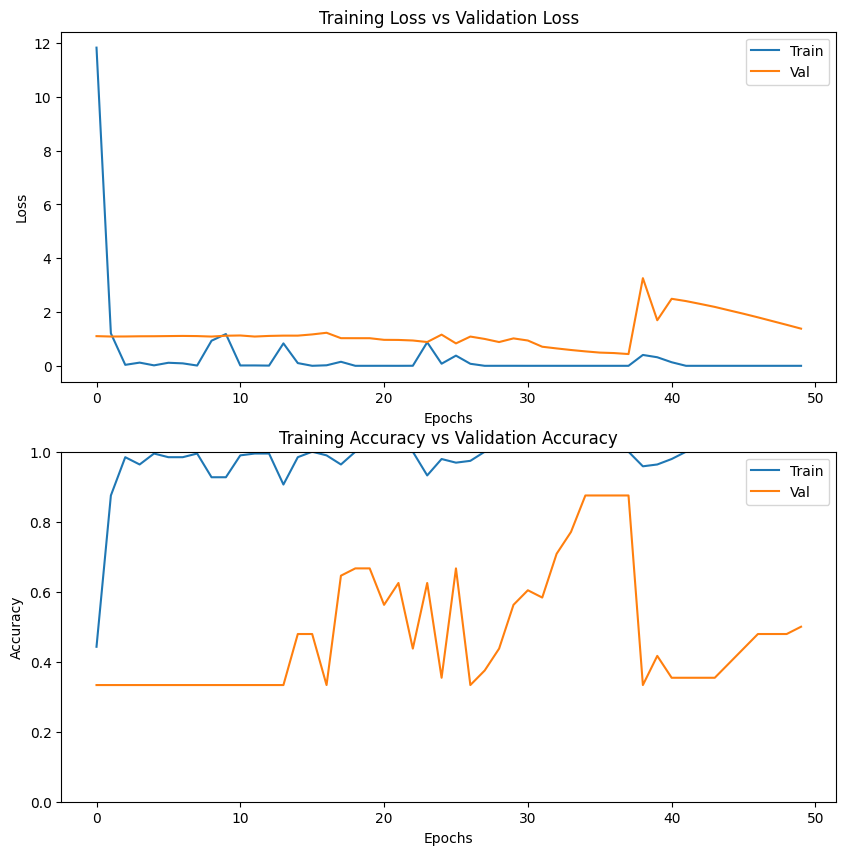

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


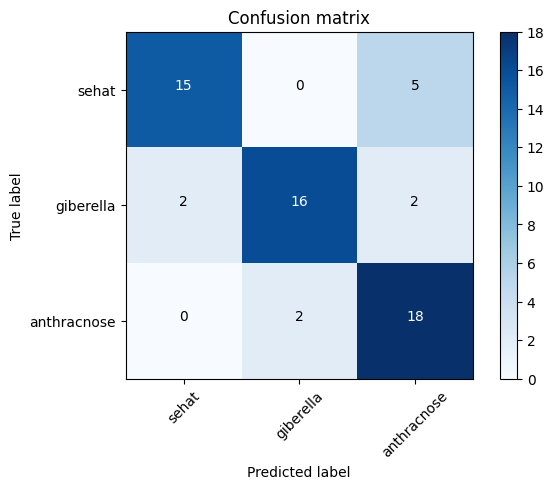

In [ ]:
model.load_weights('alexnet-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.89      0.80      0.84        20
           2       0.72      0.90      0.80        20

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



In [ ]:
!cp alexnet-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4191 - loss: 3.2701
Epoch 1: val_accuracy improved from -inf to 0.47917, saving model to alexnet-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4336 - loss: 3.2117 - val_accuracy: 0.4792 - val_loss: 1.0954
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8813 - loss: 0.6105
Epoch 2: val_accuracy did not improve from 0.47917
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8819 - loss: 0.6078 - val_accuracy: 0.3333 - val_loss: 1.0980
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9469 - loss: 0.2581
Epoch 3: val_accuracy did not improve from 0.47917
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9463 - loss: 0.2560 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9553 - loss: 0.1132
Epoch 4: val_accuracy did not improve from 0.47917
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9542 - loss: 0.1166

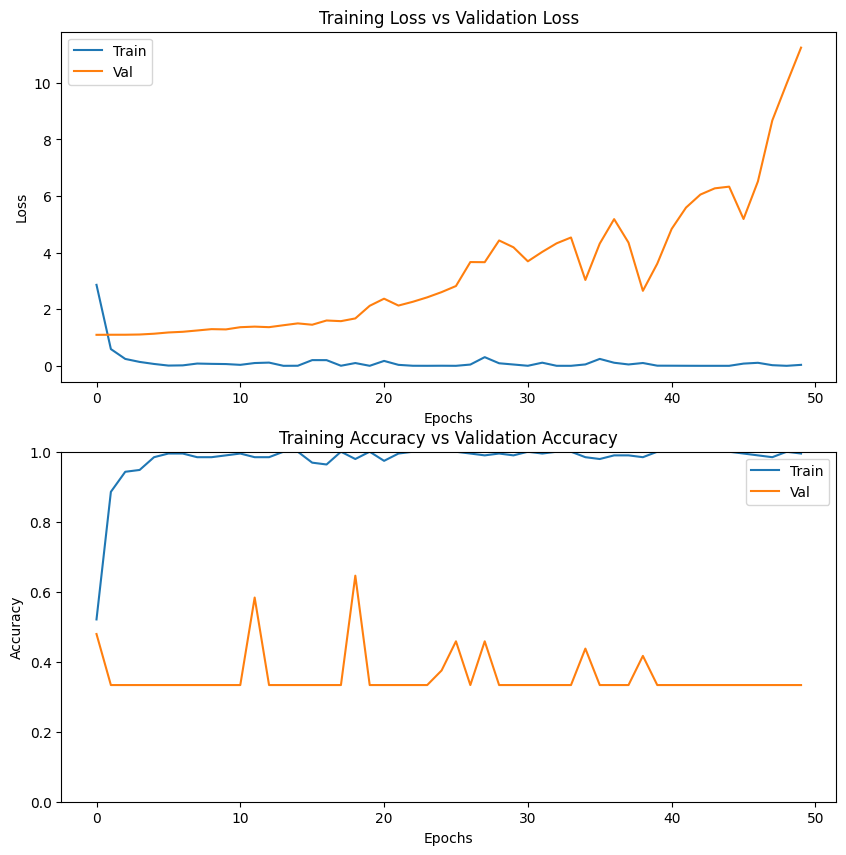

In [ ]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


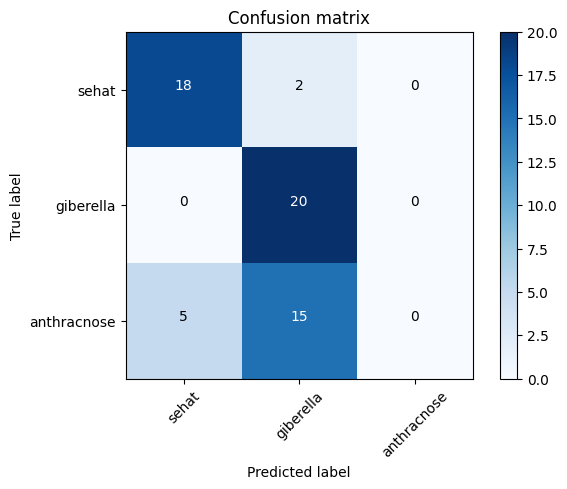

In [ ]:
model.load_weights('alexnet-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.54      1.00      0.70        20
           2       0.00      0.00      0.00        20

    accuracy                           0.63        60
   macro avg       0.44      0.63      0.51        60
weighted avg       0.44      0.63      0.51        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp alexnet-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## ResNet101

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/original/test")
X_test = X_test / 255

In [ ]:
model = ResNet101(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.3001 - loss: 1.9257
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3056 - loss: 1.8928 - val_accuracy: 0.3333 - val_loss: 1.1006
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3244 - loss: 1.4545
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.3249 - loss: 1.4503 - val_accuracy: 0.3333 - val_loss: 1.1034
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2826 - loss: 1.3455
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.2854 - loss: 1.3388 - val_accuracy: 0.3333 - val_loss: 1.1078
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.2651 - loss: 1.2456
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.2682 - loss

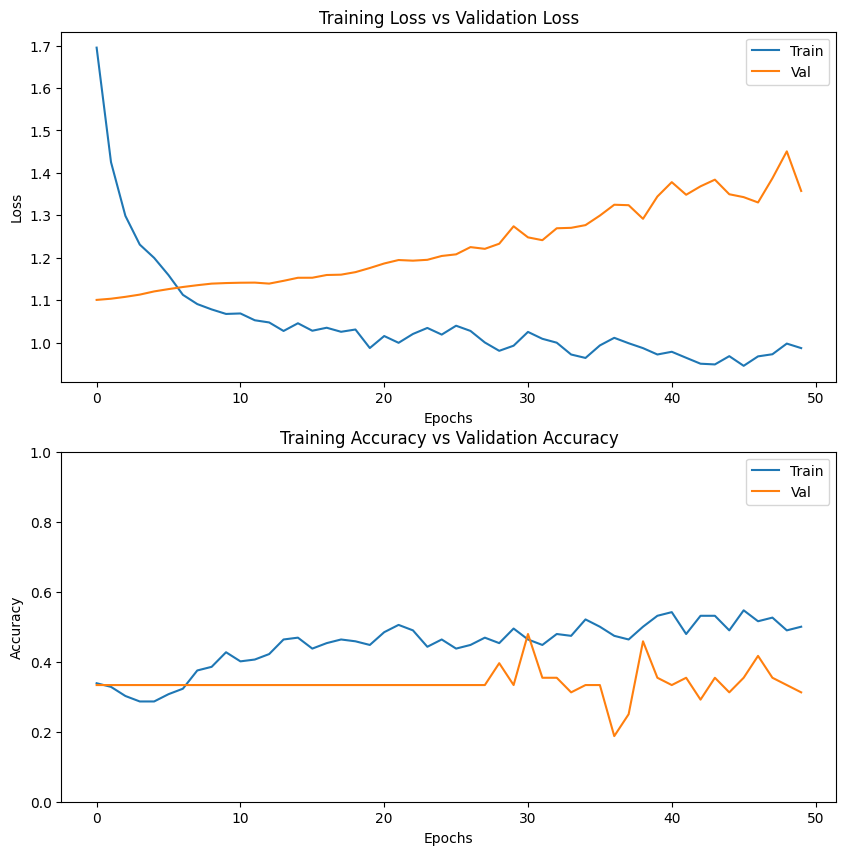

In [ ]:
plot_history(history.history)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


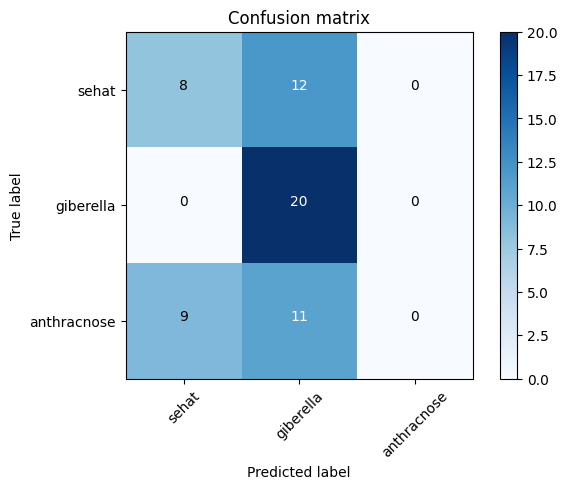

In [ ]:
model.load_weights('resnet101-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43        20
           1       0.47      1.00      0.63        20
           2       0.00      0.00      0.00        20

    accuracy                           0.47        60
   macro avg       0.31      0.47      0.36        60
weighted avg       0.31      0.47      0.36        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp resnet101-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSPROP

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.4339 - loss: 1.3168
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.4359 - loss: 1.3139 - val_accuracy: 0.3333 - val_loss: 1.3762
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7056 - loss: 0.6751
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.7112 - loss: 0.6675 - val_accuracy: 0.3333 - val_loss: 2.1651
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8451 - loss: 0.4438
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.8420 - loss: 0.4463 - val_accuracy: 0.3333 - val_loss: 3.1875
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9112 - loss: 0.3393
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 0.9090 - l

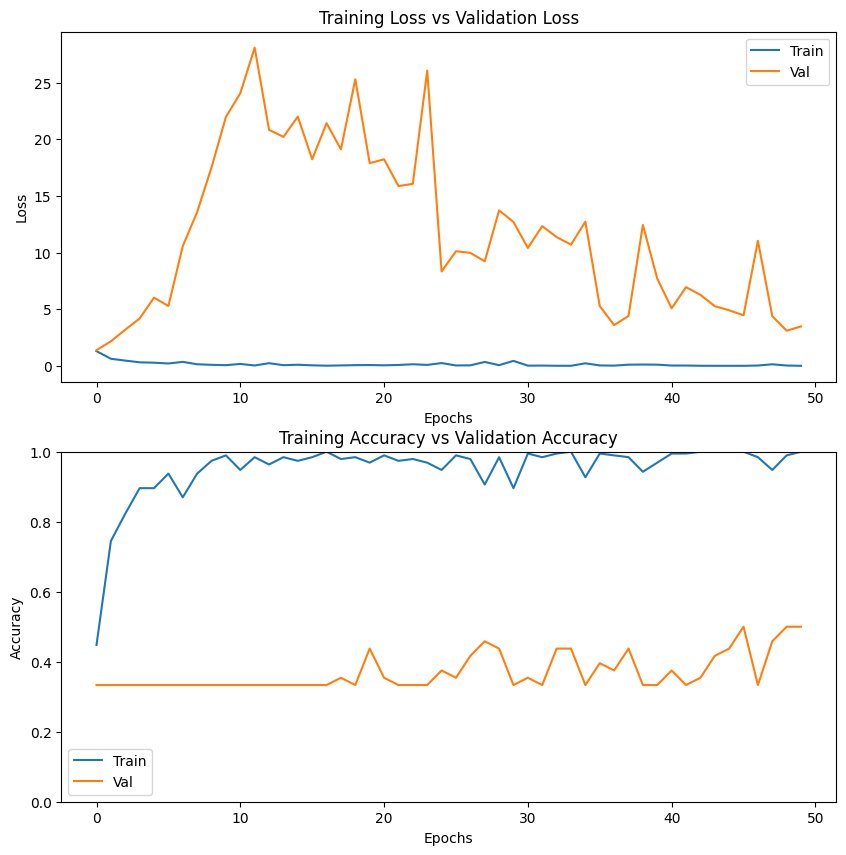

In [ ]:
plot_history(history.history)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 420 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


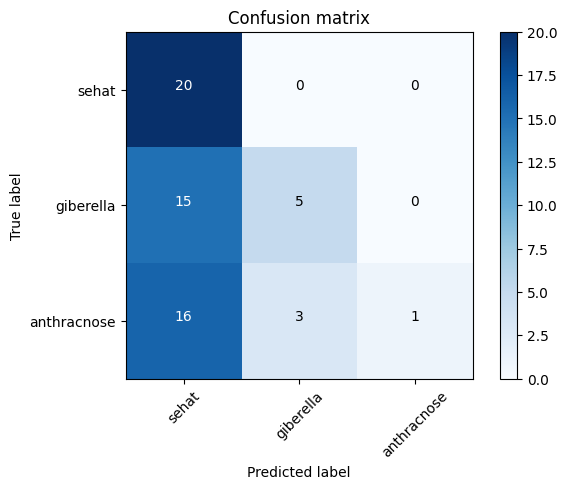

In [ ]:
model.load_weights('resnet101-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56        20
           1       0.62      0.25      0.36        20
           2       1.00      0.05      0.10        20

    accuracy                           0.43        60
   macro avg       0.67      0.43      0.34        60
weighted avg       0.67      0.43      0.34        60



In [ ]:
!cp resnet101-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to resnet101-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.4167 - val_loss: 7.2742
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9701 - loss: 0.0846
Epoch 2: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.9706 - loss: 0.0837 - val_accuracy: 0.3333 - val_loss: 13.0025
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9434 - loss: 0.3308
Epoch 3: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.9463 - loss: 0.3092 - val_accuracy: 0.3750 - val_loss: 14.9684
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9705 - loss: 0.0611
Epoch 4: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.9710 - 

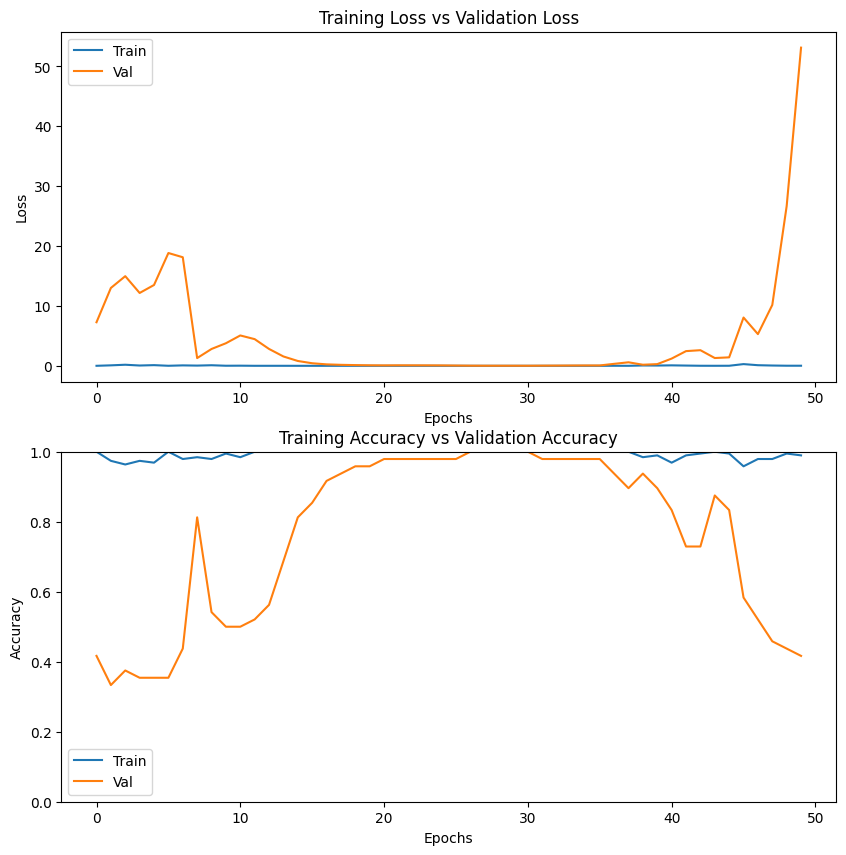

In [ ]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 10s 11s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


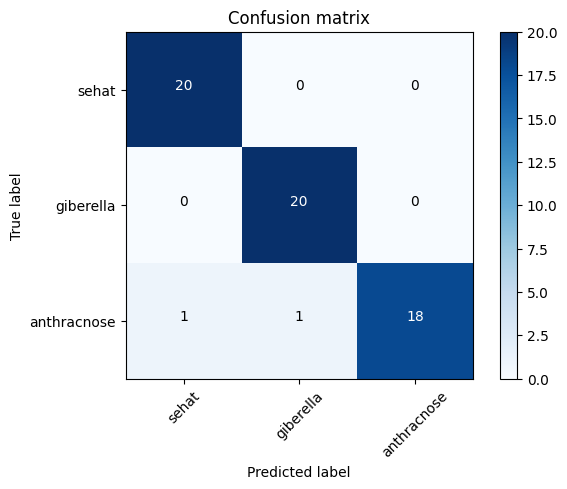

In [ ]:
model.load_weights('resnet101-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      1.00      0.98        20
           2       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [ ]:
!cp resnet101-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

# Data CLAHE

## VGG16

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


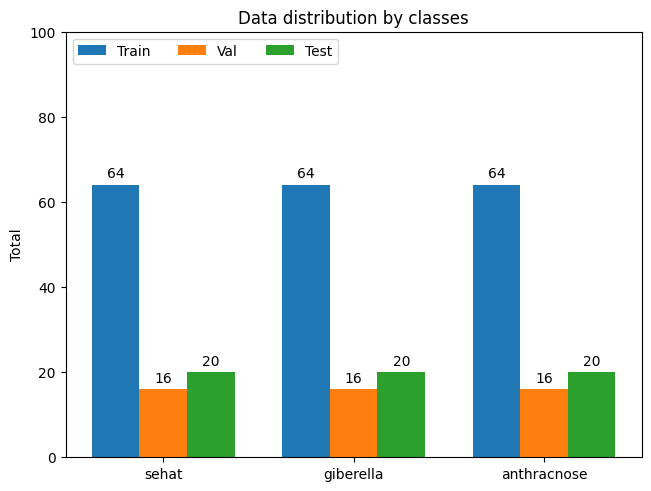

In [ ]:
plot_distribution_data(y_train, y_val, y_test)

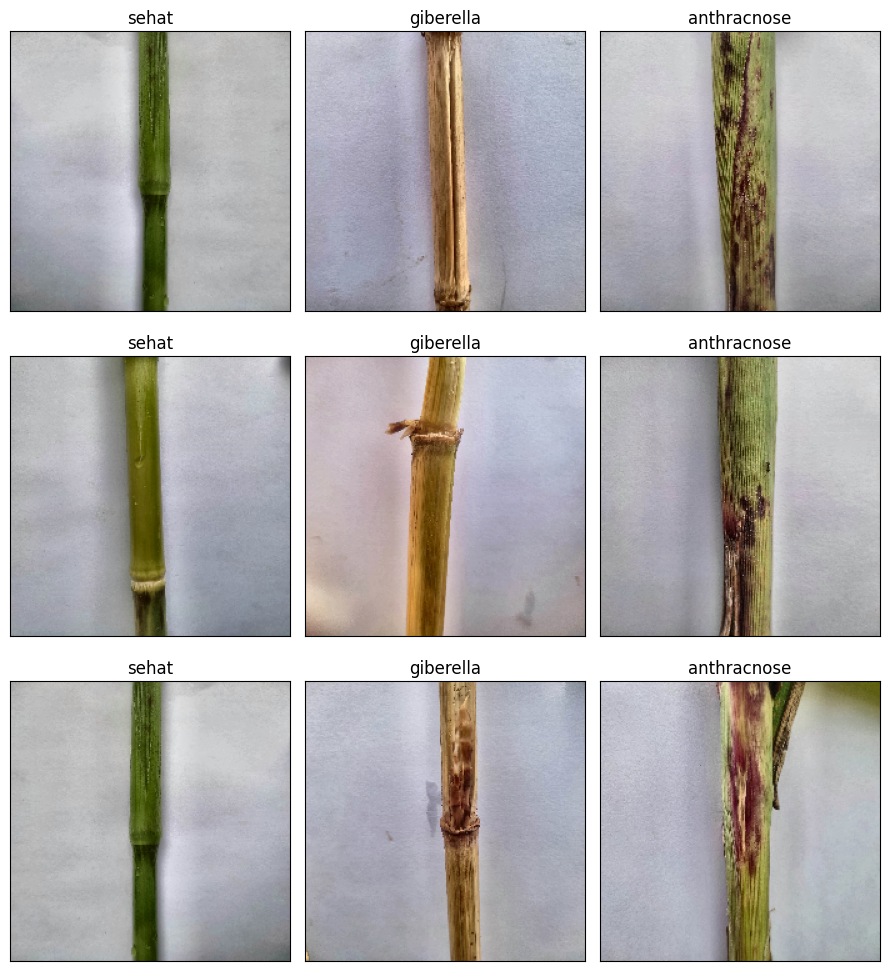

In [ ]:
show_sample_images(data=(X_train, y_train), n_images=3)

In [ ]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 134,272,835 (512.21 MB)

 Non-trainable params: 0 (0.00 B)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-clahe-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4496 - loss: 1.0986
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to vgg16-clahe-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.4404 - loss: 1.0986 - val_accuracy: 0.4167 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4254 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.4212 - loss: 1.0986 - val_accuracy: 0.4167 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.3867 - loss: 1.0989
Epoch 3: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.3895 - loss: 1.0988 - val_accuracy: 0.4167 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4398 - loss: 1.0987
Epoch 4: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.4357 - loss: 1.0987

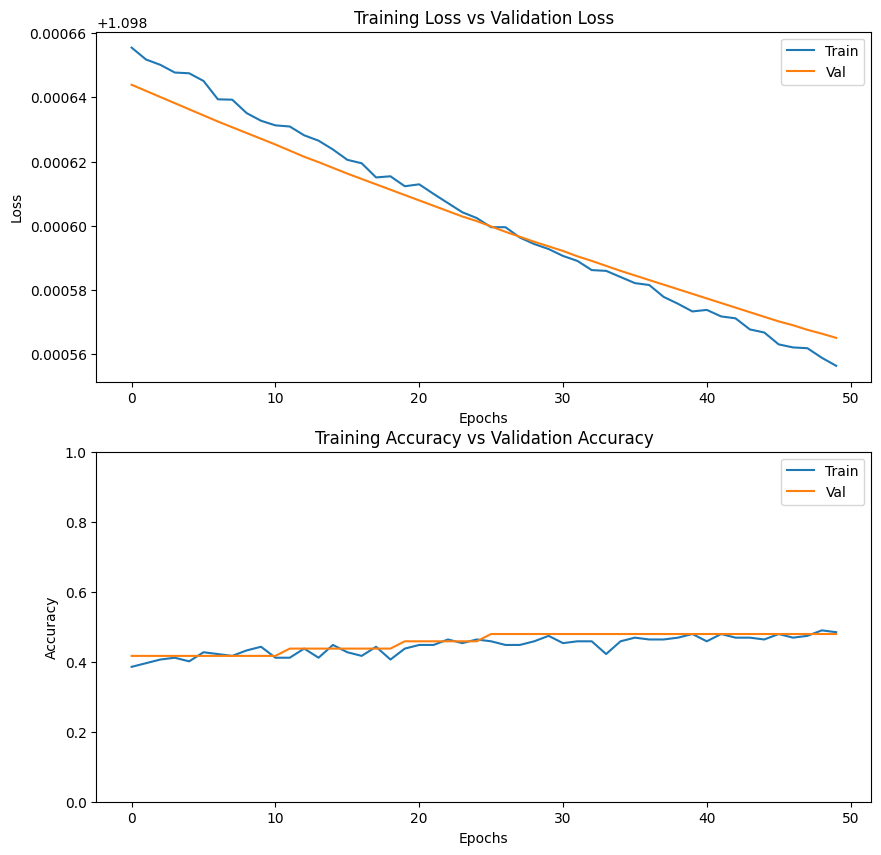

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


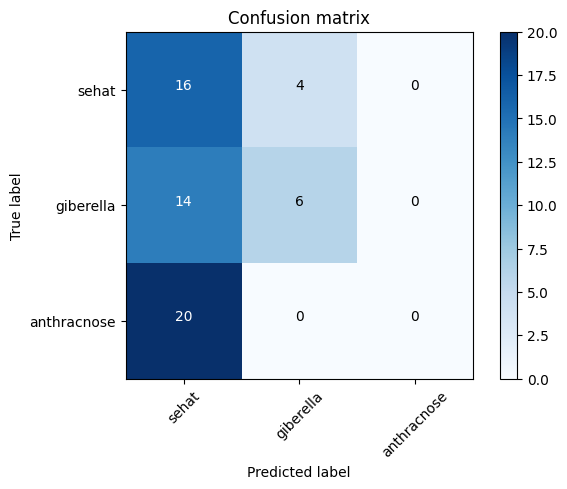

In [ ]:
model.load_weights('vgg16-clahe-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.80      0.46        20
           1       0.60      0.30      0.40        20
           2       0.00      0.00      0.00        20

    accuracy                           0.37        60
   macro avg       0.31      0.37      0.29        60
weighted avg       0.31      0.37      0.29        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp vgg16-clahe-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSprop optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-clahe-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.3178 - loss: 1.0997
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-clahe-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3141 - loss: 1.0998 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3661 - loss: 1.0985
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.3615 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0979
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3189 - loss: 1.0986
Epoch 3: val_accuracy improved from 0.33333 to 0.39583, saving model to vgg16-clahe-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3158 - loss: 1.0986 - val_accuracy: 0.3958 - val_loss: 1.0976
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4222 - loss: 1.0977
Epoch 4: val_accuracy improved from 0.39583 to 0.58333, saving model 

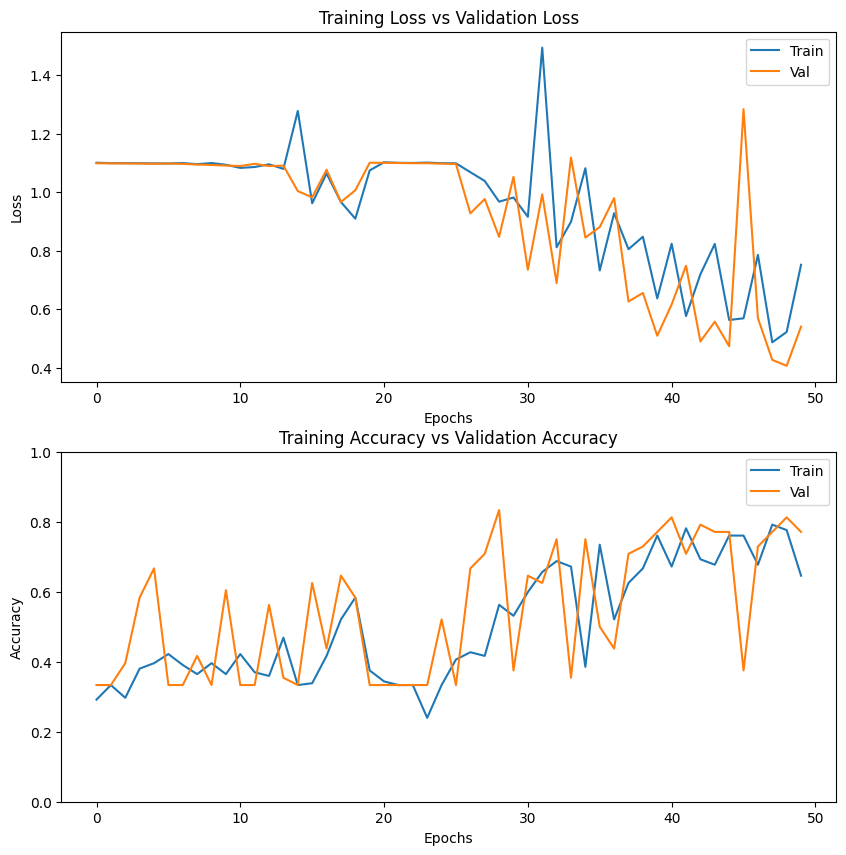

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step


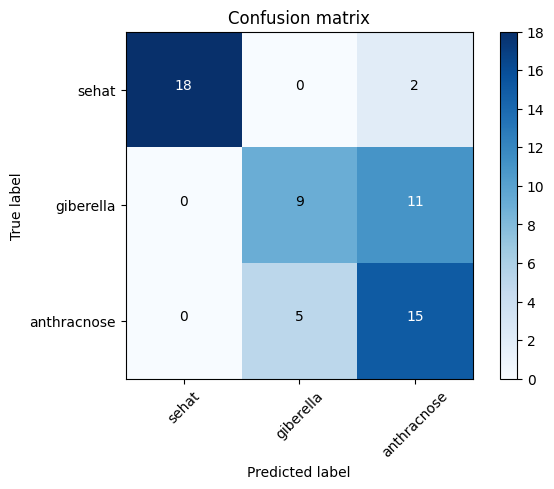

In [ ]:
model.load_weights('vgg16-clahe-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.64      0.45      0.53        20
           2       0.54      0.75      0.62        20

    accuracy                           0.70        60
   macro avg       0.73      0.70      0.70        60
weighted avg       0.73      0.70      0.70        60



In [ ]:
!cp vgg16-clahe-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-clahe-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3766 - loss: 1.1010
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.3690 - loss: 1.1011 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.3158 - loss: 1.0986
Epoch 2: val_accuracy improved from 0.33333 to 0.64583, saving model to vgg16-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.3168 - loss: 1.0986 - val_accuracy: 0.6458 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4262 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.64583
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.4196 - loss: 1.0986 - val_accuracy: 0.5833 - val_loss: 1.0983
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4977 - loss: 1.0982
Epoch 4: val_accuracy did not improve from 0.64583
6/6 ━━━━━━━━━━━━━━━━━━━━

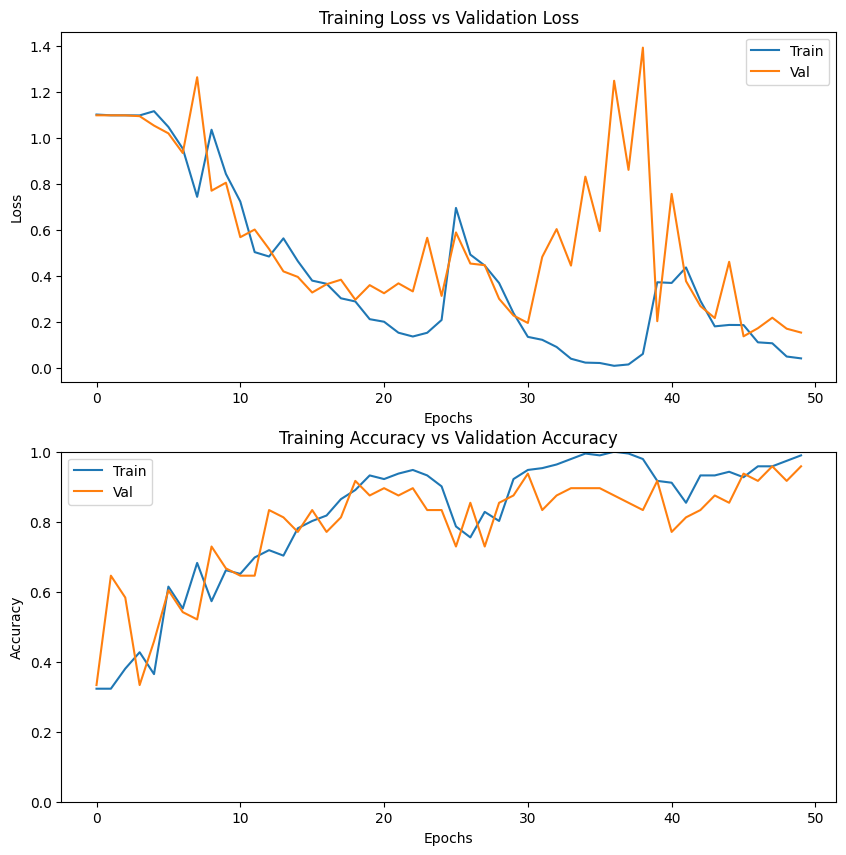

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 635ms/step


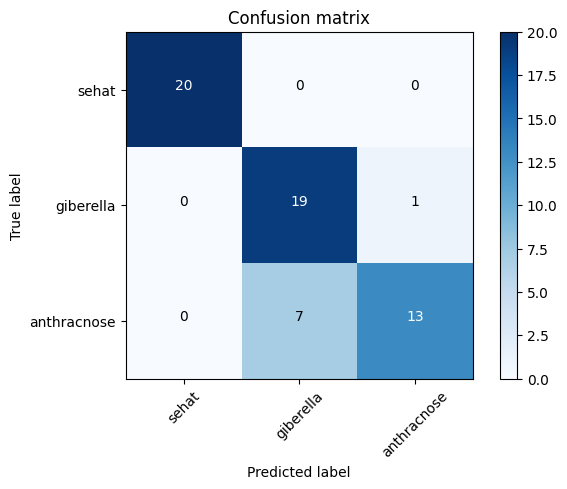

In [ ]:
model.load_weights('vgg16-clahe-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.73      0.95      0.83        20
           2       0.93      0.65      0.76        20

    accuracy                           0.87        60
   macro avg       0.89      0.87      0.86        60
weighted avg       0.89      0.87      0.86        60



In [ ]:
!cp vgg16-clahe-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## VGG19

In [9]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train


100%|██████████| 64/64 [01:16<00:00,  1.19s/it]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


In [20]:
model = VGG19(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [11]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-clahe-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.3240 - loss: 1.0986
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-clahe-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.3253 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.3398 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 660ms/step - accuracy: 0.3388 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.3875 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step - accuracy: 0.3798 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.3514 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.3488 - loss: 1.098

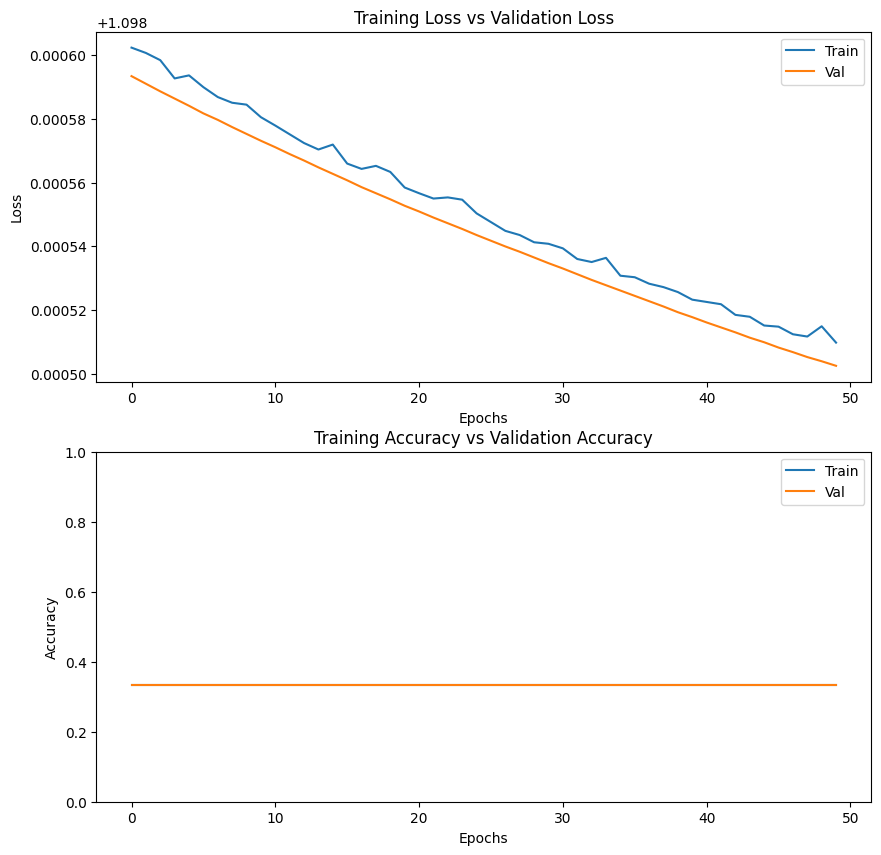

In [12]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 10s/step


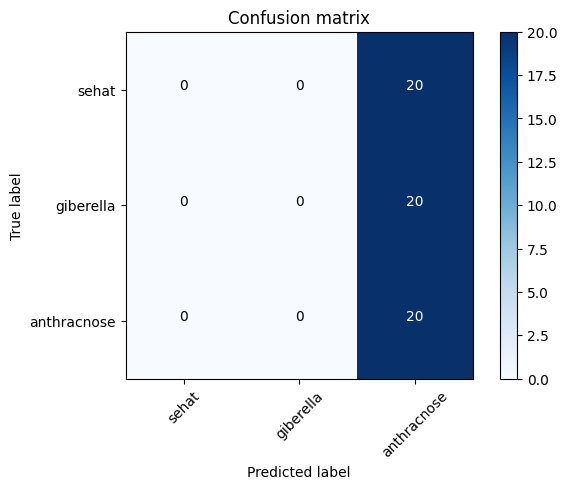

In [13]:
model.load_weights('vgg19-clahe-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### RMSprop optimizer

In [16]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-clahe-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.3059 - loss: 1.0993
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-clahe-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3068 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.3911 - loss: 1.0990
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.3828 - loss: 1.0992 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.3560 - loss: 1.0985
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - accuracy: 0.3528 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3206 - loss: 1.0987
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 691ms/step - accuracy: 0.3209 - loss: 1.

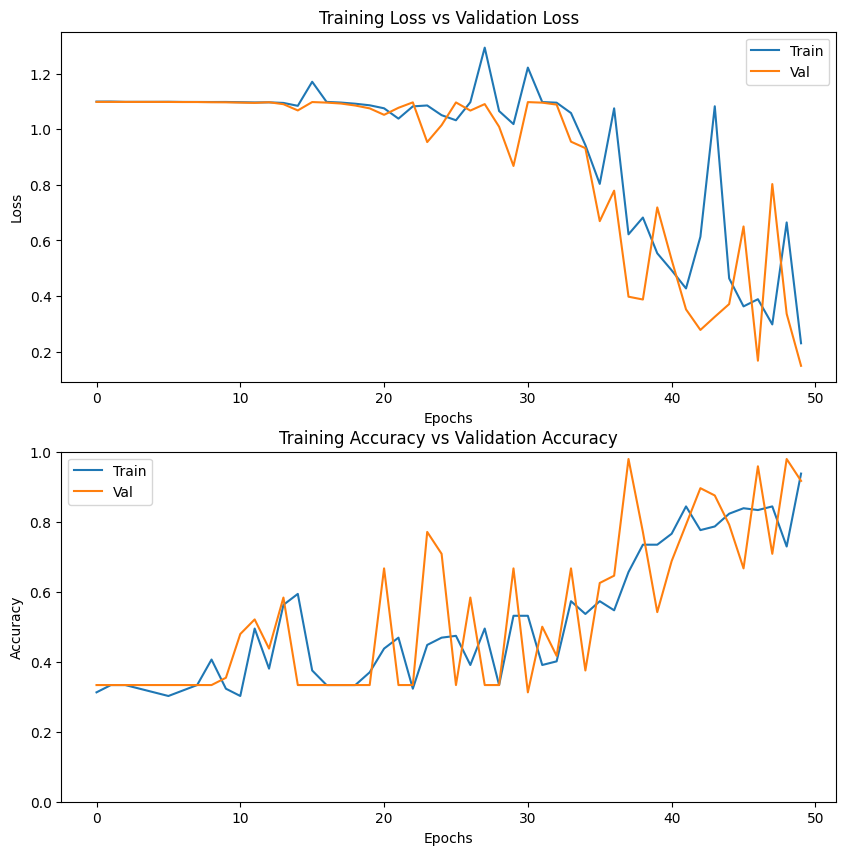

In [17]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step


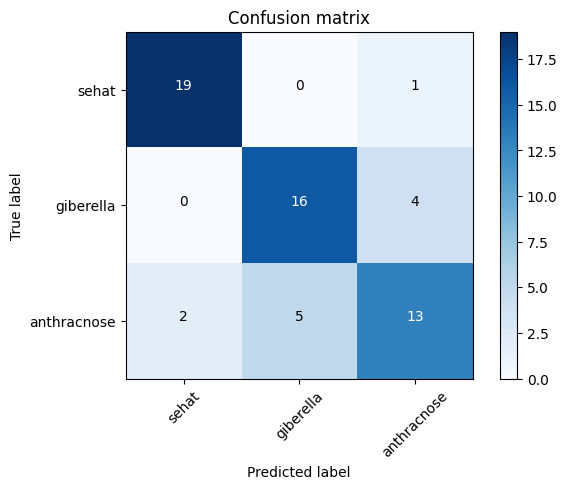

In [18]:
model.load_weights('vgg19-clahe-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.76      0.80      0.78        20
           2       0.72      0.65      0.68        20

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



### Adam optimizer

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-clahe-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.3345 - loss: 1.0995
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 85s 15s/step - accuracy: 0.3314 - loss: 1.0994 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.2954 - loss: 1.0989
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.2949 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.3135 - loss: 1.0988
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 696ms/step - accuracy: 0.3163 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.3498 - loss: 1.0987
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 695ms/step - accuracy: 0.3475 - loss: 1.09

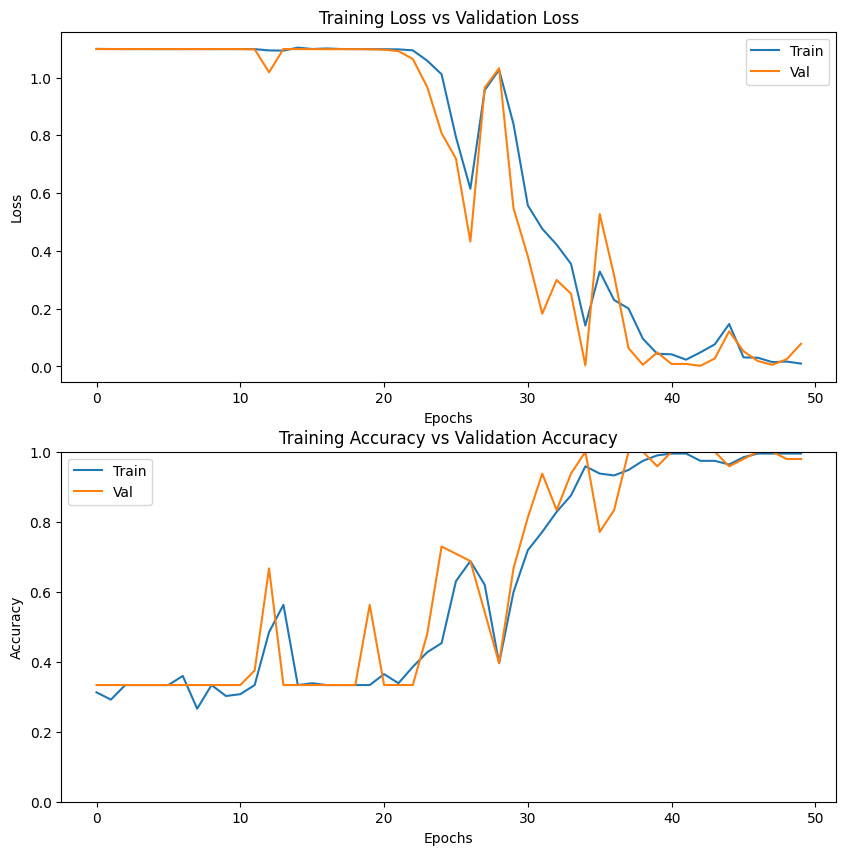

In [22]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


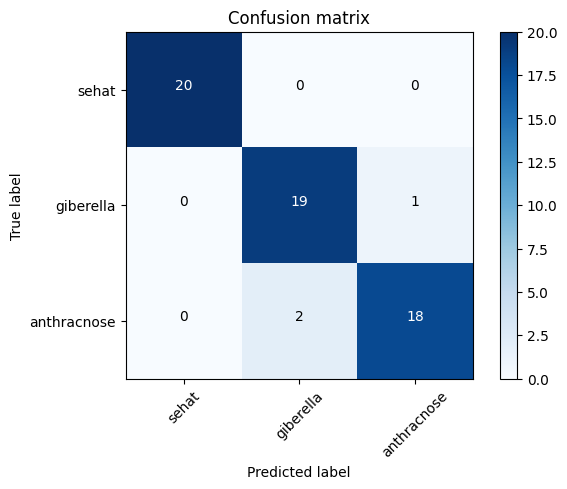

In [23]:
model.load_weights('vgg19-clahe-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      0.95      0.93        20
           2       0.95      0.90      0.92        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [26]:
!cp vgg19-clahe-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## AlexNet

In [42]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train", (227, 227))
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val", (227, 227))
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test", (227, 227))
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train


100%|██████████| 64/64 [00:03<00:00, 17.49it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val


100%|██████████| 16/16 [00:00<00:00, 17.98it/s]


Loading /content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test


100%|██████████| 20/20 [00:01<00:00, 17.91it/s]


In [53]:
model = Sequential([
    layers.Input(shape=(227, 227, 3)),
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=2),
    layers.Flatten(),
    layers.Dense(4096,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │          12,2

 Total params: 58,299,139 (222.39 MB)

 Trainable params: 58,296,387 (222.38 MB)

 Non-trainable params: 2,752 (10.75 KB)

### SGD optimizer

In [44]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-clahe-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4270 - loss: 2.3024
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to alexnet-clahe-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4225 - loss: 2.3149 - val_accuracy: 0.3333 - val_loss: 1.0981
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4447 - loss: 1.8015
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4481 - loss: 1.7855 - val_accuracy: 0.3333 - val_loss: 1.0999
Epoch 3/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4753 - loss: 1.9012
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4734 - loss: 1.8771 - val_accuracy: 0.3333 - val_loss: 1.1009
Epoch 4/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5391 - loss: 1.4483
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5353 - loss: 1.4757 - va

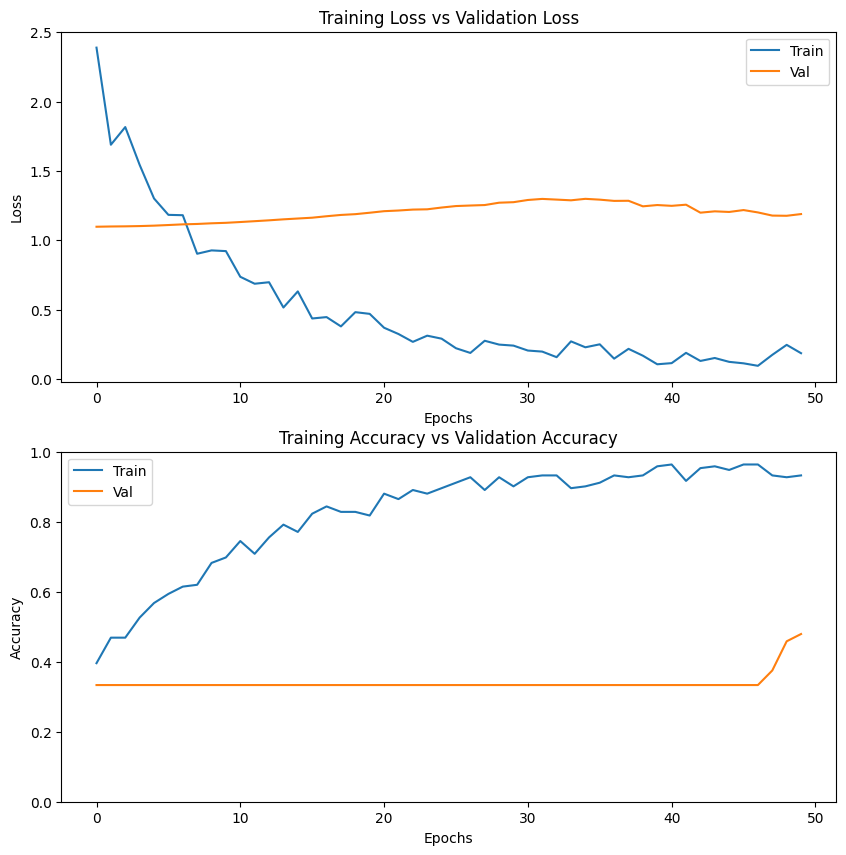

In [45]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


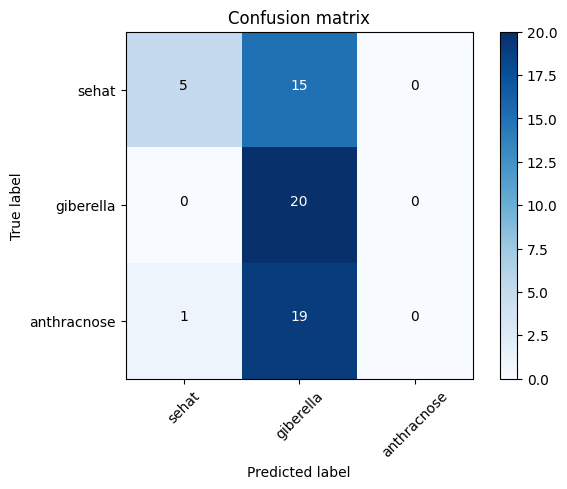

In [46]:
model.load_weights('alexnet-clahe-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.25      0.38        20
           1       0.37      1.00      0.54        20
           2       0.00      0.00      0.00        20

    accuracy                           0.42        60
   macro avg       0.40      0.42      0.31        60
weighted avg       0.40      0.42      0.31        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp alexnet-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### RMSPROP

In [49]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-clahe-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4396 - loss: 13.7304
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to alexnet-clahe-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.4452 - loss: 13.8204 - val_accuracy: 0.3333 - val_loss: 1.0938
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7959 - loss: 1.1537
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8080 - loss: 1.0794 - val_accuracy: 0.3333 - val_loss: 1.0878
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.2344
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9430 - loss: 0.2371 - val_accuracy: 0.3333 - val_loss: 1.0901
Epoch 4/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8603 - loss: 0.9861
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8809 - loss: 0.838

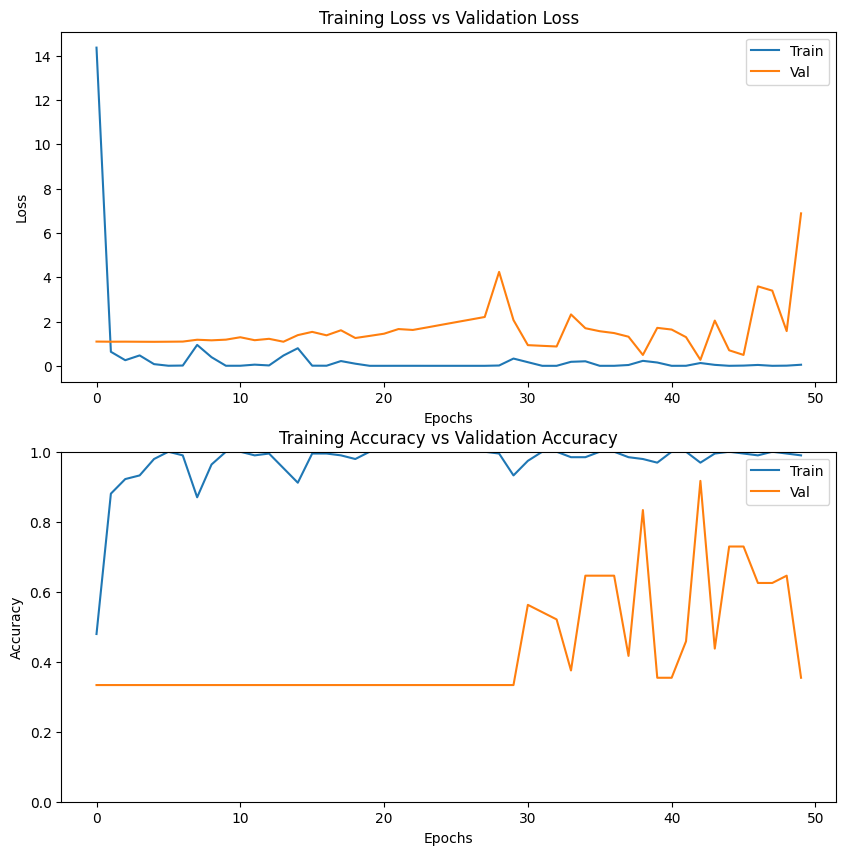

In [50]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


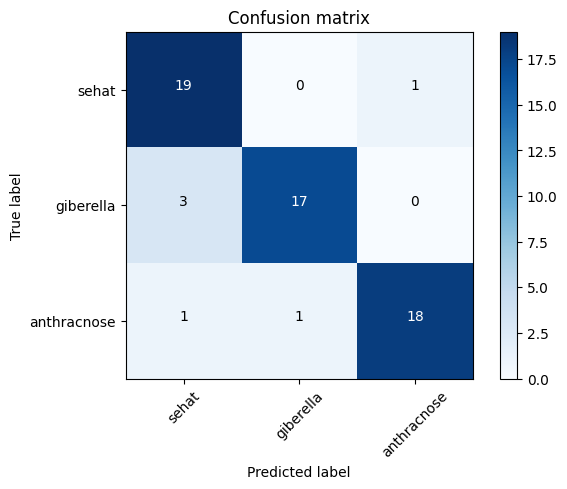

In [51]:
model.load_weights('alexnet-clahe-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.94      0.85      0.89        20
           2       0.95      0.90      0.92        20

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



In [ ]:
!cp alexnet-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam

In [54]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='alexnet-clahe-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4600 - loss: 2.8840
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to alexnet-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.4687 - loss: 2.8786 - val_accuracy: 0.3333 - val_loss: 1.0940
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7912 - loss: 1.5820
Epoch 2: val_accuracy improved from 0.33333 to 0.41667, saving model to alexnet-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 86s 10s/step - accuracy: 0.7965 - loss: 1.5228 - val_accuracy: 0.4167 - val_loss: 1.0885
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9029 - loss: 0.3952
Epoch 3: val_accuracy improved from 0.41667 to 0.50000, saving model to alexnet-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.9071 - loss: 0.3820 - val_accuracy: 0.5000 - val_loss: 1.0894
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9617 - loss: 0.1323
Epoch 4: val_accuracy imp

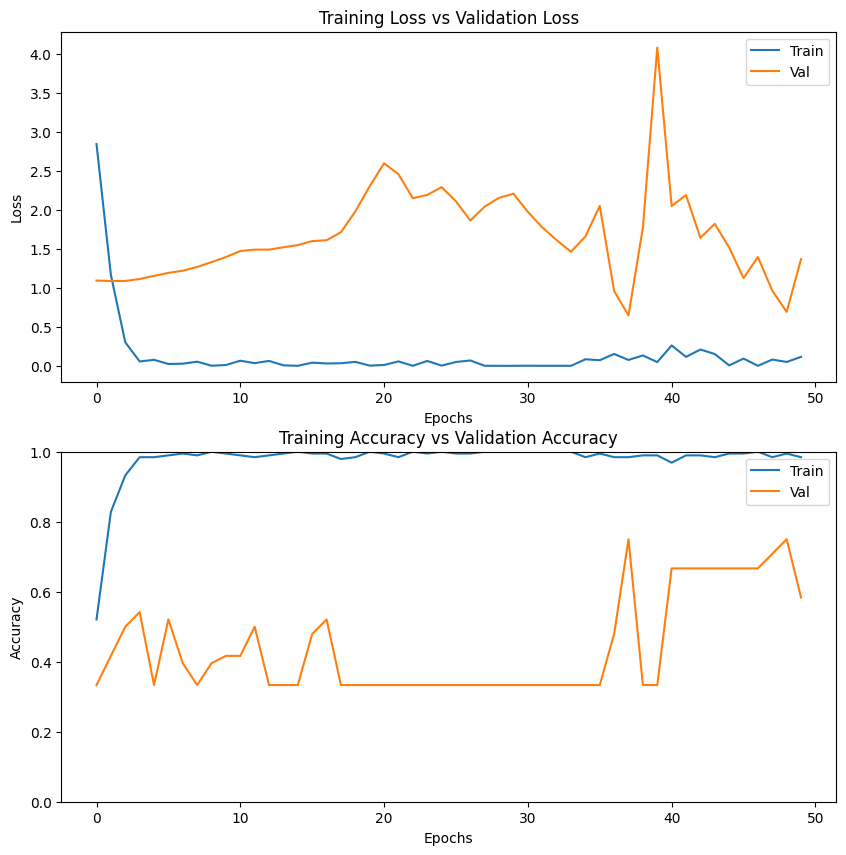

In [55]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 900ms/step


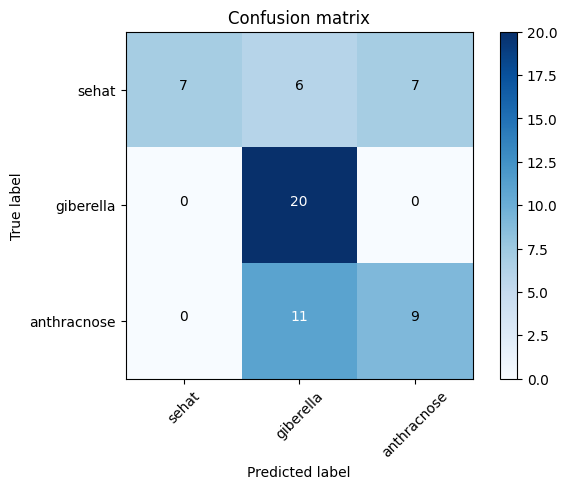

In [56]:
model.load_weights('alexnet-clahe-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.35      0.52        20
           1       0.54      1.00      0.70        20
           2       0.56      0.45      0.50        20

    accuracy                           0.60        60
   macro avg       0.70      0.60      0.57        60
weighted avg       0.70      0.60      0.57        60



In [ ]:
!cp alexnet-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

## ResNet101

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-batang-jagung/dataset/clahe/test")
X_test = X_test / 255

In [37]:
model = ResNet101(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [28]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-clahe-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.3576 - loss: 1.9708
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-clahe-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.3542 - loss: 1.9677 - val_accuracy: 0.3333 - val_loss: 1.0991
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3457 - loss: 1.6068
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.3447 - loss: 1.6039 - val_accuracy: 0.3333 - val_loss: 1.1000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.3293 - loss: 1.4139
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - accuracy: 0.3313 - loss: 1.4054 - val_accuracy: 0.3333 - val_loss: 1.1034
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.3679 - loss: 1.1412
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.3622 - loss: 1.

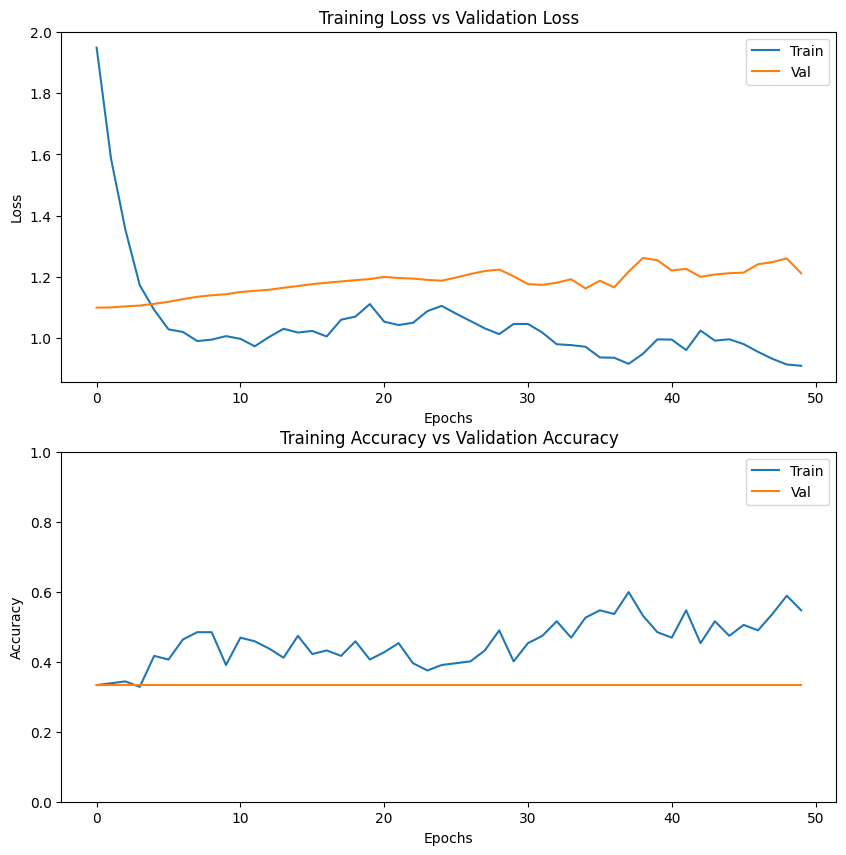

In [29]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step


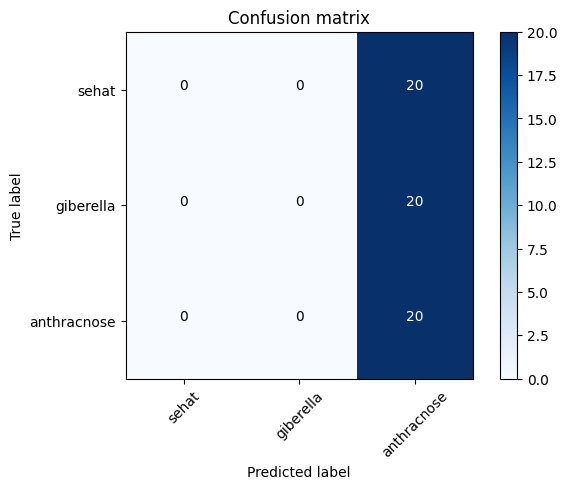

In [30]:
model.load_weights('resnet101-clahe-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### RMSPROP

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-clahe-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4881 - loss: 1.4994
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-clahe-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.4861 - loss: 1.5095 - val_accuracy: 0.3333 - val_loss: 1.1004
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6915 - loss: 0.7276
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.6932 - loss: 0.7232 - val_accuracy: 0.3333 - val_loss: 1.1281
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7334 - loss: 0.6997
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - accuracy: 0.7365 - loss: 0.6881 - val_accuracy: 0.3333 - val_loss: 1.2221
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8571 - loss: 0.3095
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - accuracy: 0.8619 - loss

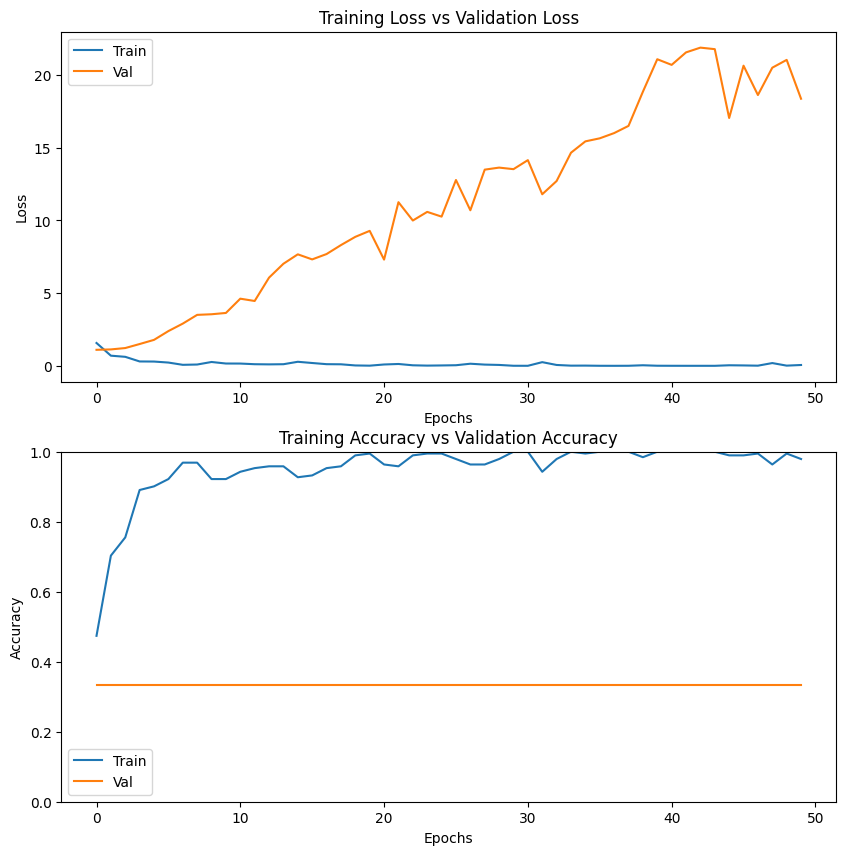

In [34]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step


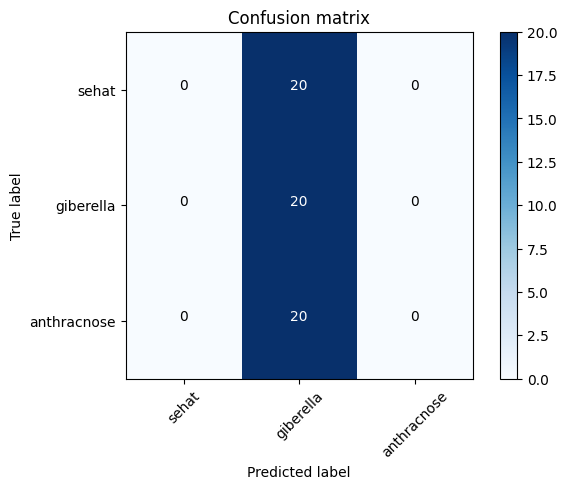

In [35]:
model.load_weights('resnet101-clahe-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.33      1.00      0.50        20
           2       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp resnet101-clahe-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights

### Adam

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-clahe-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5187 - loss: 1.0308
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-clahe-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5264 - loss: 1.0243 - val_accuracy: 0.3333 - val_loss: 1.1066
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6536 - loss: 0.7562
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.6562 - loss: 0.7574 - val_accuracy: 0.3333 - val_loss: 1.1351
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8016 - loss: 0.5529
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.8024 - loss: 0.5507 - val_accuracy: 0.3333 - val_loss: 1.1979
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8201 - loss: 0.4939
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - accuracy: 0.8257 - loss: 

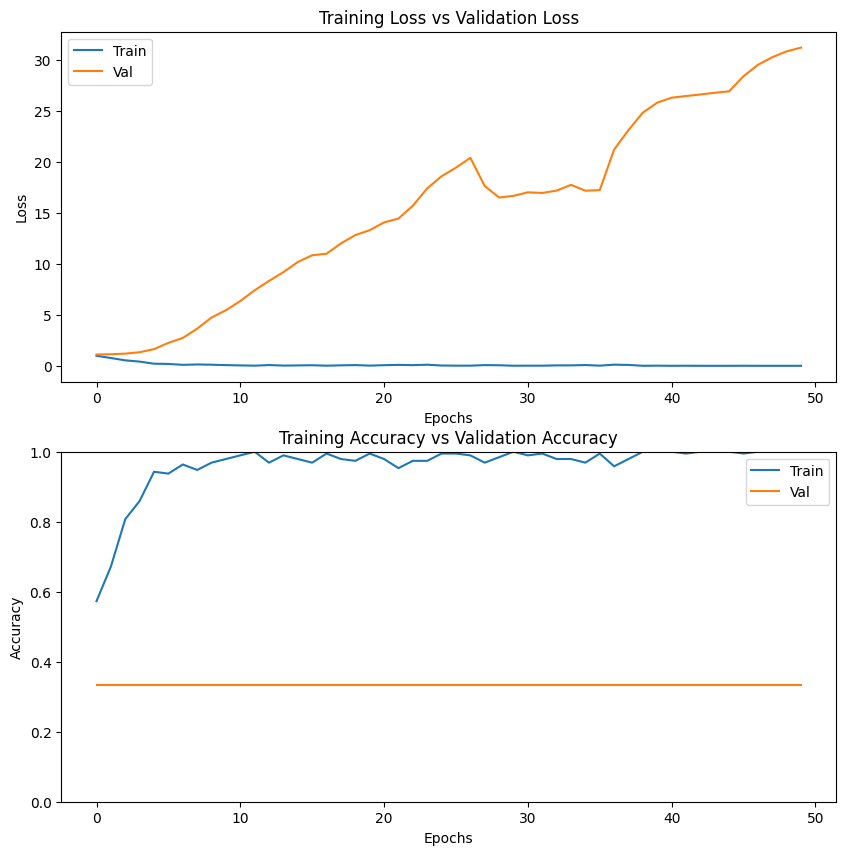

In [39]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


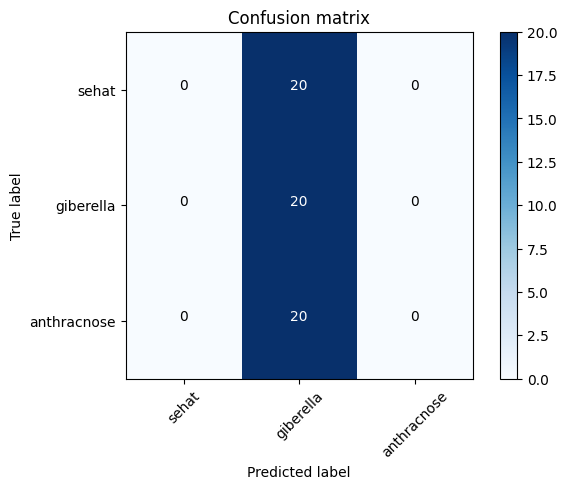

In [40]:
model.load_weights('resnet101-clahe-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.33      1.00      0.50        20
           2       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp resnet101-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-batang-jagung/model-weights